I created a nlp classifier for real and fake news based on the kaggle dataset. It uses a Support Vector Machine (SVM) combined with TF-IDF (Term Frequency-Inverse Document Frequency) for feature extraction. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
data=pd.read_csv('news_articles.csv')

In [3]:
data.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [4]:
# Check the size of the dataset
dataset_size = data.shape

In [4]:
# Check the balance of the dataset
label_distribution = data['label'].value_counts()

In [4]:
# Check for missing values
missing_values = data[['text', 'label']].isnull().sum()

dataset_size, label_distribution, missing_values

((2096, 12),
 Fake    1294
 Real     801
 Name: label, dtype: int64,
 text     46
 label     1
 dtype: int64)

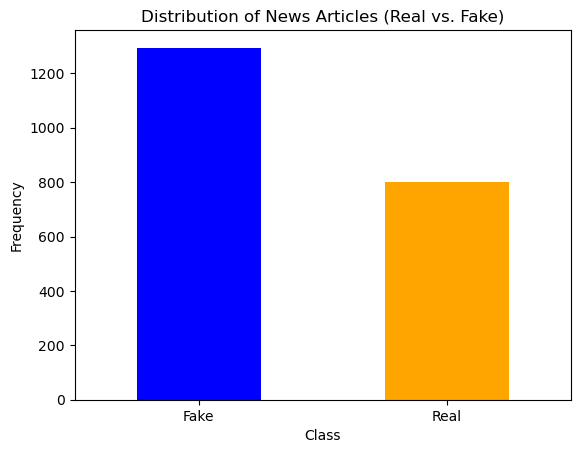

In [5]:
# Display the distribution of Real vs. Fake news
class_distribution = data['label'].value_counts()

class_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of News Articles (Real vs. Fake)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the class names horizontal for readability
plt.show()

In [6]:
# Drop rows with any missing values in 'text' or 'label' columns
data.dropna(subset=['text', 'label'], inplace=True)

In [7]:
# Check the unique values in the 'label' column
print("Unique labels in the dataset:", data['label'].unique())

In [7]:
# Generate word clouds for Real and Fake news
real_news = ' '.join(data[data['label'] == 'Real']['text'].tolist())
fake_news = ' '.join(data[data['label'] == 'Fake']['text'].tolist())

In [7]:
# Create and generate a word cloud image for Real news
real_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords.words('english'), 
                min_font_size = 10).generate(real_news)

Unique labels in the dataset: ['Real' 'Fake']


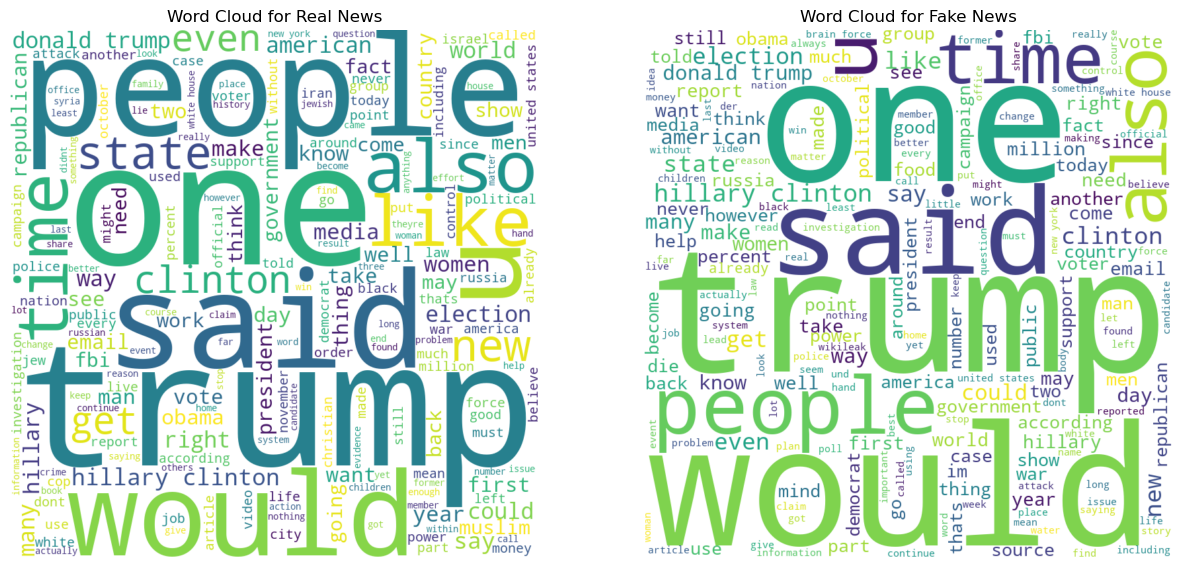

In [7]:
# Create and generate a word cloud image for Fake news
fake_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', 
                stopwords = stopwords.words('english'), 
                min_font_size = 10).generate(fake_news)

# Display the generated WordClouds
plt.figure(figsize=(15, 7))


plt.subplot(1, 2, 1)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Real News')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')

plt.show()

Word cloud of word frequency in the dataset, which shows that the most frequent words are quite similar for both real and fake news in the dataset.

In [8]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

In [9]:
# Define the preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize by splitting the text
    tokens = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize each word
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Re-create text from tokens
    return ' '.join(lemmatized_tokens)

In [10]:
# Apply the preprocessing function to the 'text' and 'title' columns
data['text_cleaned'] = data['text'].apply(preprocess_text)
data['title_cleaned'] = data['title'].apply(preprocess_text)

In [11]:
# Display the first few rows to check the preprocessing
print(data[['text_cleaned', 'title_cleaned']].head())

                                        text_cleaned  \
0  print pay back money plus interest entire fami...   
1  attorney general loretta lynch plead fifth bar...   
2  red state fox news sunday reported morning ant...   
3  email kayla mueller prisoner tortured isi chan...   
4  email healthcare reform make america great sin...   

                                       title_cleaned  
0           muslim busted stole million govt benefit  
1         attorney general loretta lynch plead fifth  
2  breaking weiner cooperating fbi hillary email ...  
3  pin drop speech father daughter kidnapped kill...  
4  fantastic trump point plan reform healthcare b...  


In [12]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.7)  # Ignore terms that appear in more than 70% of the documents

In [12]:
# Fit and transform the vectorizer on the cleaned text data
tfidf_train = tfidf_vectorizer.fit_transform(data['text_cleaned'])

In [12]:
# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['label'])

In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_train, labels, test_size=0.2, random_state=42)

In [12]:
# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear')

In [12]:
# Train the classifier
svm_classifier.fit(X_train, y_train)

In [12]:
# Predict on the test set
y_pred = svm_classifier.predict(X_test)

In [12]:
# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7439024390243902
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       249
           1       0.77      0.50      0.60       161

    accuracy                           0.74       410
   macro avg       0.75      0.70      0.71       410
weighted avg       0.75      0.74      0.73       410



The model created is decently acurate at an overall 75 percent. Being more accurate on fake news (77 percent) than real news (74 percent).

In [13]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

In [13]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

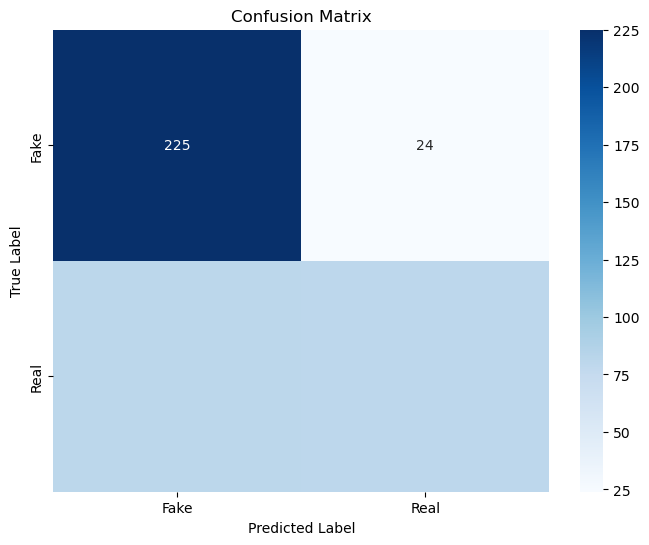

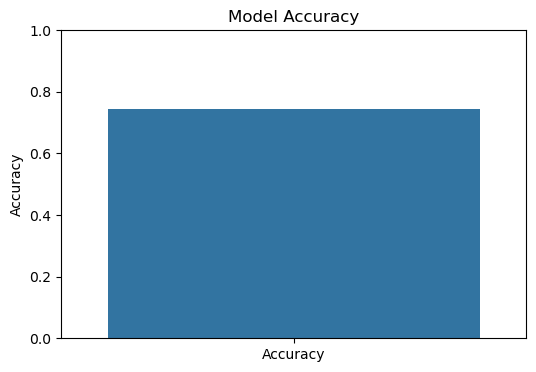

In [13]:
# Plotting the accuracy as a bar chart
accuracy = accuracy_score(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.barplot(x=['Accuracy'], y=[accuracy])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

Here I created a function to input a new news title to be classified as real or fake. However, due to the low amount of examples in the data, the model is overfitted and predicts almost all titles as fake

In [18]:
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

def classify_news_title(title, tfidf_vectorizer, svm_classifier, label_encoder):
    # Preprocess the input title
    preprocessed_title = preprocess_text(title)
    
    # Vectorize the preprocessed title
    title_features = tfidf_vectorizer.transform([preprocessed_title])
    
    # Classify the title using the trained model
    prediction = svm_classifier.predict(title_features)
    
    # Decode the predicted label
    predicted_label = label_encoder.inverse_transform(prediction)[0]
    return predicted_label


# Example usage:
input_title = "Cricket World Cup: Why India looks unstoppable"
result = classify_news_title(input_title, tfidf_vectorizer, svm_classifier, label_encoder)
print(f"The news title '{input_title}' is classified as: {result}")


The news title 'Cricket World Cup: Why India looks unstoppable' is classified as: Fake
